In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dataclasses
import json
import os

# PRO

In [ ]:
import sys
sys.path.append('/Users/ankamenskiy/SmartDota/')

from src.data.api.OpenDota.pro_matches_dataloader import ProMatchesDataloader


downloader = ProMatchesDataloader(num_threads=4, verbose=True, use_key=True)

TOTAL_AMOUNT_LOAD = 6_000
path = f'../../cache/pro_{TOTAL_AMOUNT_LOAD}'
downloader.load(path)

TOTAL_AMOUNT_SAVE = 10_000
path = f'../../cache/pro_{TOTAL_AMOUNT_SAVE}'
matches = downloader(TOTAL_AMOUNT_SAVE - TOTAL_AMOUNT_LOAD)
downloader.save(path)

print('Loaded matches: ', len(downloader.data))
print('Requests count: ', downloader.requests_cnt)

# d = [dataclasses.asdict(elem) for elem in downloader.data]
# with open('a.json', 'w') as f:
#     f.write(json.dumps(d))

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x110ee1630>>
Traceback (most recent call last):
  File "/Users/ankamenskiy/miniconda3/envs/py310/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


# PUBLIC DOWNLOAD

In [3]:
import sys
sys.path.append('/Users/ankamenskiy/SmartDota/')

from src.data.api.OpenDota.public_matches_dataloader import PublicMatchesDataloader


downloader = PublicMatchesDataloader(
    patch_timestamp_start=1740776400,
    patch_timestamp_end=1746392400,
    num_threads=4,
    batch_size=500,
    verbose=True, 
    # debug=True,
    use_key=True,
    first_id=8193890327
)

TOTAL_AMOUNT_LOAD = 0 # 100_000
# path = f'../../cache/public_{TOTAL_AMOUNT_LOAD}'
# downloader.load(path)

TOTAL_AMOUNT_SAVE = 20_000
path = f'../../cache/public_{TOTAL_AMOUNT_SAVE}'
matches = downloader(TOTAL_AMOUNT_SAVE - TOTAL_AMOUNT_LOAD)
downloader.save(path)

print('Loaded matches: ', len(downloader.data))
print('Requests count: ', downloader.requests_cnt)

# d = [dataclasses.asdict(elem) for elem in downloader.data]
# with open('a.json', 'w') as f:
#     f.write(json.dumps(d))

e881de34-fef0-4d0e-8e45-851c569ba3a2


Loading matches batched progress:: 0it [00:00, ?it/s]

Loading public matches data from OpenDota:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
# TOTAL_AMOUNT_LOAD = 100_000
# path = f'../../cache/public_{TOTAL_AMOUNT_LOAD}'
# downloader.load(path)

Last match index: 7512775201


In [24]:
import numpy as np

ids = [elem.match_id for elem in downloader.data]
print(min([elem.start_time for elem in downloader.data]))
len(downloader.data), np.unique(ids).shape

1703440467


(110000, (108937,))

In [19]:
# from src.data.dataclasses.match import MatchData
# from src.data.dataclasses.pro_match import ProMatchData

# import sys
# sys.path.append('/Users/ankamenskiy/SmartDota/')


# d = []
# for match in downloader.data:
#     d.append(
#         MatchData(
#                 match_id=match.match_id,
#                 public_match_data=None,
#                 pro_match_data=ProMatchData(
#                     match_id=match.pro_match_data.match_id,
#                     duration=None,
#                     start_time=None,
#                     radiant_team_id=match.pro_match_data.radiant_team_id,
#                     dire_team_id=match.pro_match_data.dire_team_id,
#                     leagueid=match.pro_match_data.leagueid,
#                     series_type=match.pro_match_data.series_type,
#                     radiant_score=match.pro_match_data.radiant_score,
#                     dire_score=match.pro_match_data.dire_score,
#                     radiant_win=match.pro_match_data.radiant_win,
#                 ),
#                 barracks_status_dire=match.barracks_status_dire,
#                 barracks_status_radiant=match.barracks_status_radiant,
#                 dire_score=match.dire_score,
#                 draft_timings=match.draft_timings,
#                 picks_bans=match.picks_bans,
#                 duration=match.duration,
#                 first_blood_time=match.first_blood_time,
#                 leagueid=match.leagueid,
#                 objectives=match.objectives,
#                 radiant_gold_adv=match.radiant_gold_adv,
#                 radiant_score=match.radiant_score,
#                 radiant_win=match.radiant_win,
#                 radiant_xp_adv=match.radiant_xp_adv,
#                 teamfights=match.teamfights,
#                 tower_status_dire=match.tower_status_dire,
#                 tower_status_radiant=match.match_id,
#                 version=match.version,
#                 series_id=match.series_id,
#                 radiant_team=match.radiant_team,
#                 dire_team=match.dire_team,
#                 players=match.players,
#                 patch=match.patch,
#                 throw=match.throw,
#                 comeback=match.comeback,
#         )
#     )

In [40]:
import requests
from collections import defaultdict
import numpy as np


def fetch_match_data(match_id):
    """
    Fetch match data from OpenDota API.
    """
    url = f"https://api.opendota.com/api/matches/{match_id}"
    response = requests.get(url)
    match_data = response.json()
    return match_data

def calculate_kill_differences(match_data):
    """
    Calculate kill differences by each minute.
    """
    # Initialize dictionaries to store kills by team and minute
    kills_by_minute = {}
    for i in range(len(match_data['radiant_gold_adv'])):
        kills_by_minute[i] = {'radiant': 0, 'dire': 0}
    
    # Process each kill
    for player in match_data.get('players', []):
        team = 'radiant' if player['isRadiant'] else 'dire'
        for kill_time in player.get('kills_log', []):
            minute = kill_time['time'] // 60  # Convert time to minute
            kills_by_minute[minute][team] += 1

    diff_arr = [0]
    for minute in sorted(kills_by_minute.keys()):
        radiant_kills = kills_by_minute[minute].get('radiant', 0)
        dire_kills = kills_by_minute[minute].get('dire', 0)
        diff_arr.append(diff_arr[-1] + radiant_kills - dire_kills)

    return diff_arr

def main(match_id):
    # match_id = 7706030717 # 7705829352  # Replace with an actual match ID
    match_data = fetch_match_data(match_id)
    kill_differences = calculate_kill_differences(match_data)
    times = list(np.arange(0, len(kill_differences) * 60, 60))

    limit = min(len(times), min(len(match_data['radiant_gold_adv']), min(len(match_data['radiant_xp_adv']), len(kill_differences))))

    return times[:limit], match_data['radiant_gold_adv'][:limit], match_data['radiant_xp_adv'][:limit], kill_differences[:limit], match_data['radiant_win']
    
    # for minute, diff in kill_differences.items():
    #     print(f"Minute {minute}: Kill difference = {diff}")


match_id = 7706030717
times, radiant_gold_adv, radiant_exp_adv, kill_differences, radiant_win = main(match_id)

print(times)
print(radiant_gold_adv)
print(radiant_exp_adv)
print(kill_differences)
print(radiant_win)

[0, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780, 840, 900, 960, 1020, 1080, 1140, 1200, 1260, 1320, 1380, 1440, 1500, 1560, 1620, 1680, 1740, 1800, 1860, 1920, 1980, 2040, 2100, 2160, 2220, 2280, 2340, 2400, 2460, 2520, 2580, 2640, 2700, 2760, 2820, 2880, 2940, 3000]
[-100, 67, 29, 490, 351, 73, 905, 1019, 933, 1787, 2280, 2604, 2966, 2382, 3167, 1170, 3924, 2166, 2447, 2195, 3043, 5182, 6262, 7533, 6508, 8775, 6967, 6158, 8134, 9209, 7967, 6047, 8299, 7659, 8018, 5956, 1410, -1962, -2884, -2774, -5353, -4188, -557, 1119, 1582, 2004, 5330, 5566, 8617, 6768, 2530]
[-70, -87, 139, 69, -207, -542, 309, 482, 690, 1550, 1770, 1990, 2794, 3035, 4771, 3506, 8450, 6237, 6830, 6720, 8188, 12206, 11699, 14566, 13377, 15772, 11338, 12152, 18249, 17097, 15302, 13652, 18434, 16843, 18874, 11609, 4909, 3729, -140, 2634, -8099, -1355, 2067, 7846, 8943, 10245, 14944, 15074, 22549, 16240, 2121]
[0, 0, 0, 1, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 3, 1, 4, 1, 1, 1, 2, 4, 5, 5, 5, 7, 6, 6, 8, 9,

In [124]:

a = np.array(radiant_gold_adv)
b = np.array(radiant_exp_adv)
c = np.array(kill_differences) * 1000

d = (a + b + c) / 3

min_val = np.min(d)
max_val = np.max(d)

d = (d - min_val) / (max_val - min_val) 
d = d * 100


mean = 0.0  # Среднее значение
std = 0.15  # Стандартное отклонение

noise1 = np.random.normal(mean, std, d.shape) * 100
noise2 = np.random.normal(mean, std, d.shape) * -100
noise = noise1 + noise2 / 2


d = d + noise

# min_val = np.min(d)
# max_val = np.max(d)

# d = (d - min_val) / (max_val - min_val) 
# d = d * 100
d[0] = 0

# d = d * 100

[Text(0.5, 0, 'Время, мин'),
 Text(0, 0.5, 'Разница в Золоте/Опыте/Убийствах'),
 Text(0.5, 1.0, 'Признаки модели')]

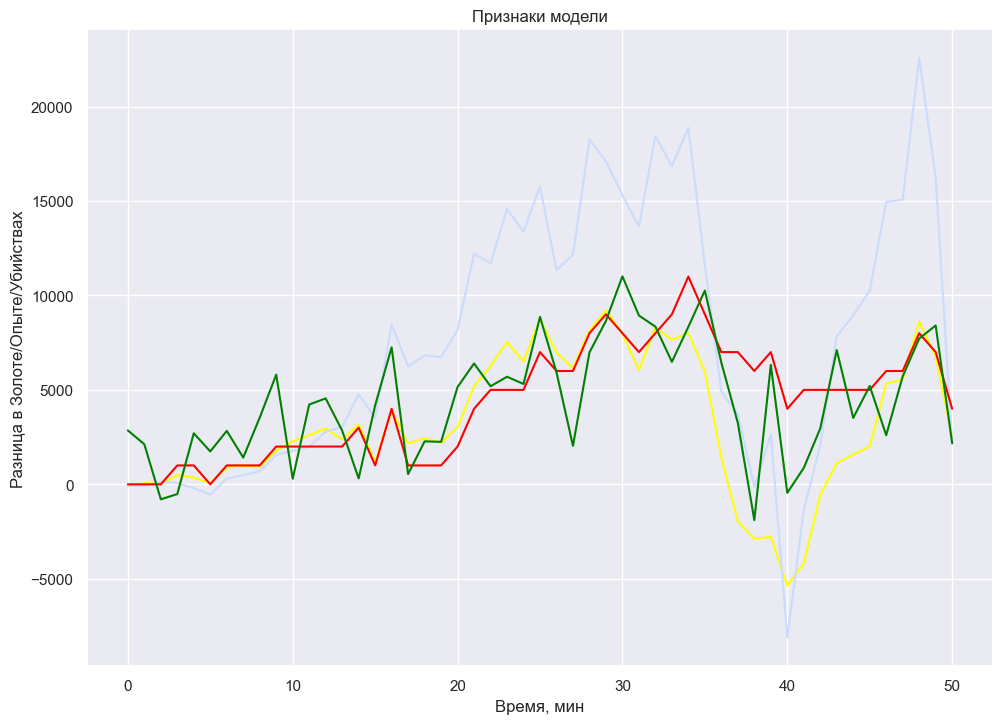

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt


rc = {'axes.edgecolor': 'white',
 'axes.facecolor': '#EAEAF2',
 'axes.labelcolor': '.15',
 'grid.color': 'white',
 'text.color': '.15',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'figure.figsize':(11.7,8.27)}
# sns.set_style("dark")
sns.set_theme(rc=rc)

minutes = [t // 60 for t in times]
kd = [k * 1000 for k in kill_differences]
pl = sns.lineplot(x=minutes, y=radiant_gold_adv, color='yellow')
pl = sns.lineplot(x=minutes, y=radiant_exp_adv, color='#cbdbfc')
pl = sns.lineplot(x=minutes, y=kd, color='red')
pl = sns.lineplot(x=minutes, y=d, color='green')

pl.set(xlabel ="Время, мин", ylabel = "Разница в Золоте/Опыте/Убийствах", title ='Признаки модели')


[Text(0.5, 0, 'Время, мин'),
 Text(0, 0.5, 'Вероятность победы, %'),
 Text(0.5, 1.0, 'График вероятности победы модели')]

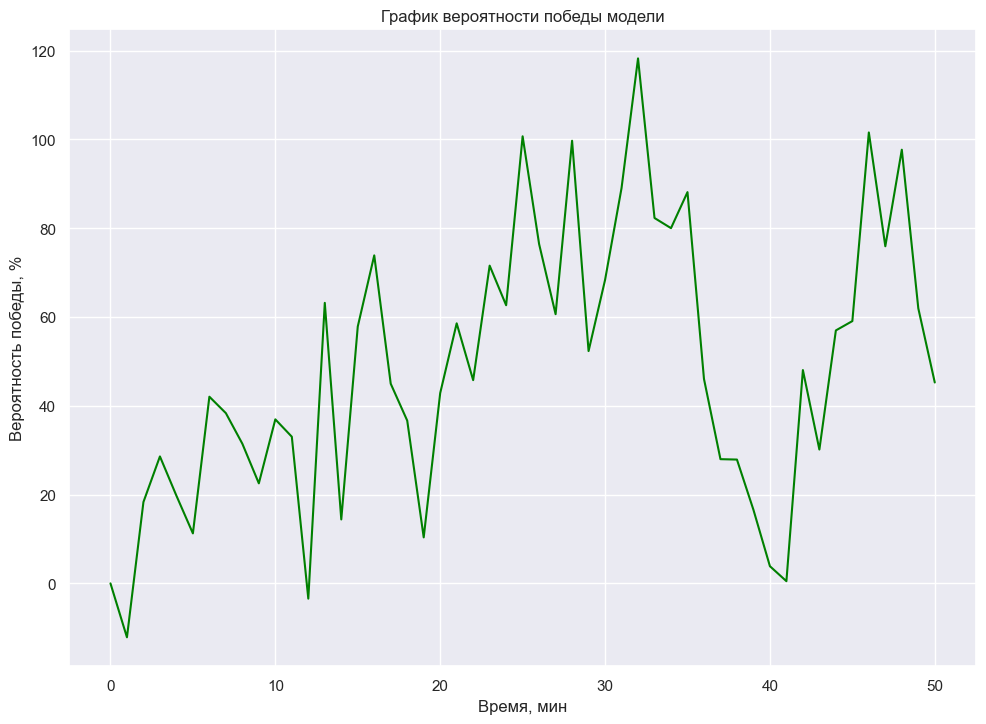

In [125]:
pl = sns.lineplot(x=minutes, y=d, color='green')
pl.set(xlabel ="Время, мин", ylabel = "Вероятность победы, %", title ='График вероятности победы модели')

<Axes: >

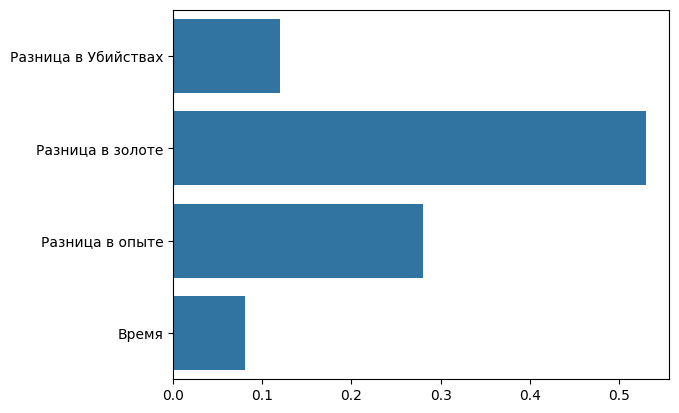

In [4]:
import seaborn as sns

sns.barplot(
    x=[0.12, 0.53, 0.28, 0.08],
    y=['Разница в Убийствах', 'Разница в золоте','Разница в опыте' ,'Время']
)

In [1]:
0.12 + 0.59 + 0.28

0.99

In [3]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
